## Cosine Similarity

### 코사인 유사도 

    - 문서1: 저는 사과 좋아요
    - 문서2: 저는 바나나 좋아요
    - 문서3: 저는 바나나 좋아요 저는 바나나 좋아요
    => 띄어쓰기 기준 토큰화, 문서 단어 행렬
   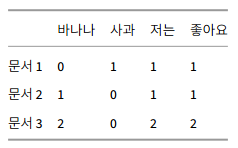

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
    return dot(A, B) / (norm(A)*norm(B))

doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

print("문서 1과 문서 2의 코사인 유사도:", cos_sim(doc1, doc2))
print("문서 1과 문서 3의 코사인 유사도:", cos_sim(doc1, doc3))
print("문서 2과 문서 3의 코사인 유사도:", cos_sim(doc2, doc3))

문서 1과 문서 2의 코사인 유사도: 0.6666666666666667
문서 1과 문서 3의 코사인 유사도: 0.6666666666666667
문서 2과 문서 3의 코사인 유사도: 1.0000000000000002


    - 문서1, 문서2간의 코사인 유사도와 문서1, 문서3의 유사도가 같다.
    - 문서2와 문서3의 코사인 유사도는 1이 나온다 이는 빈도수가 동일하게 증가하는 경우느 기존의 문서와 빈도수가 증가한 유사도는 코사인 유사도가 같다는 뜻이다.

    - 코사인 유사도의 경우 유사도를 구할 때 벡터의 방향을 방향에 초점을 두어, 문서의 길이가 다른 상황에서 비교적 공정한 비교를 할 수 있다.

### 2. 유사도를 이용한 추천 시스템 구현하기

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv("movies_metadata.csv", low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [3]:
# 상위 2만개의 샘플을 data에 저장
data = data.head(20000)

In [4]:
# overview 열에 존재하는 모든 결측값을 전부 카운트하여 출력
print("overview 열의 결측값의 수:", data["overview"].isnull().sum())

overview 열의 결측값의 수: 135


In [5]:
# 결측값을 빈 값으로 대체
data["overview"] = data["overview"].fillna("")

In [6]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(data["overview"])
print("TF-IDF 행렬의 크기(shape):", tfidf_matrix.shape)

TF-IDF 행렬의 크기(shape): (20000, 47487)


TF-IDF의 행렬의 크기는 20,000개의 행을 가지고 47,847의 열을 가지는 행렬이다. 다시말해 20,000영화를 표현하기 위해서 총 47,487개의 단어가 사용되었음을 의미한다. 또는 47,847차원의 문서 벡터가 20,000개가 존재한다고 표현할 수 있다. 

In [7]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("코사인 유사도 연산 결과:", cosine_sim.shape)

코사인 유사도 연산 결과: (20000, 20000)


코사인 유사도의 결과로 20,000행, 20,000열의 행렬을 얻는다. 이는 20,000개의 각 문서벡터와 자기 자신을 포함한 20,000개의 문서 벡터간의 유사도가 기록된 행렬.

    - 기존 데이터 프레임으로부터 영황의 타이틀을 key, 영화의 인덱스를 value로 하는 딕셔너리 title_to_index를 만들어 준다.

In [8]:
title_to_index = dict(zip(data["title"], data.index))

# title이 Father of the Bride Part II인 인덱스 리턴
idx = title_to_index["Father of the Bride Part II"]
print(idx)

4


In [9]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀의 인덱스를 가지고 온다.
    idx = title_to_index[title]
    
    # 해당 영화와 모든 영화와의 유사도를 가지고 온다.
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    #유사도에 따라 영화들을 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #가장 유사한 10개의 영화를 받아온다.
    sim_scores = sim_scores[1:11]
    
    #가장 유사한 영화의 인덱스를 얻는다.
    movies_indices = [idx[0] for idx in sim_scores]
    
    # 가장 유사한 10개의 영화의 제목을 리턴한다.
    return data["title"].iloc[movies_indices]

In [10]:
get_recommendations("The Dark Knight Rises")

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

    - 처음의 영화가 다크나이트이고 그외에도 전부 배트맨 영황인것을 확인할 수 있다.

------

### 1. 유클리드 거리(Euclidiean distance)
    - 두점 사이의 유클리드 거리의 공식은 다음과 같다.
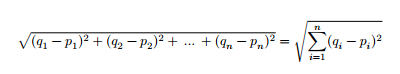

    - 여러 문서에 대해서 유사도를 구하고자 유클리드 거리 공식을 사용하는 것은 단어의 총 개수만큼의 차원으로 확장하는 것과 같다
    - 아래와 같은 DTM이 있다고 하자.
   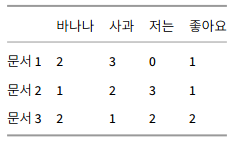

    - 단어의 개수가 4개이므로, 4차원 공간에서 3개의 문서를 배치하는 것과 같다
    - 다음과 같은 문서Q가 있다고 할때 가장 유사한 문서를 찾고자 한다.
   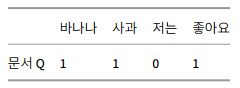

In [11]:
import numpy as np

def dist(x, y):
    return np.sqrt(np.sum(x - y)**2)

doc1 = np.array((2, 3, 0, 1))
doc2 = np.array((1, 2, 3, 1))
doc3 = np.array((2, 1, 2, 2))

docQ = np.array((1, 1, 0, 1))

print("문서 1과 문서 Q의 거리:", dist(doc1, docQ))
print("문서 2과 문서 Q의 거리:", dist(doc2, docQ))
print("문서 3과 문서 Q의 거리:", dist(doc3, docQ))

문서 1과 문서 Q의 거리: 3.0
문서 2과 문서 Q의 거리: 4.0
문서 3과 문서 Q의 거리: 4.0


    - 유클리드 거리 값이 가장 작다는 것은 문서간의 거리가 가장 가깝다는 것을 뜻한다. 따라서 문서 1이 문서 Q와 가장 유사하다고 볼 수 있다.

--------

### 자카드 유사도(Jaccard similarity)
    - A, B 두개의 집합이 있다고 할때, 합집합과 교집합의 비율을 구한다면 두 집합 A,B의 유사도를 구할 수 있다는 것이 자카드 유사도의 아이디어이다. 
    - 자카드 유사도는 0과 1사이의 값을 가지며, 두 집합이 동일하다면 1값을 가지고, 두집합의 공통 원소가 없다면 0을 가진다. 
    - 자카드 유사도를 구하는 함수를 J라고 할때 함수 J는 다음과 같다.
   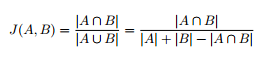

In [12]:
doc1 = "apple banana everyone like likey watch card holder"
doc2 = "apple banana counpon passport love you"

# 토큰화
tokenized_doc1 = doc1.split()
tokenized_doc2 = doc2.split()

print("문서1:", tokenized_doc1)
print("문서2:", tokenized_doc2)

문서1: ['apple', 'banana', 'everyone', 'like', 'likey', 'watch', 'card', 'holder']
문서2: ['apple', 'banana', 'counpon', 'passport', 'love', 'you']


In [13]:
union = set(tokenized_doc1).union(set(tokenized_doc2))
print("문서1과 문서2의 합집합:", union)
print("문서1과 문서2의 합집합의 개수:", len(union))

문서1과 문서2의 합집합: {'you', 'passport', 'apple', 'watch', 'holder', 'card', 'everyone', 'likey', 'like', 'love', 'banana', 'counpon'}
문서1과 문서2의 합집합의 개수: 12


In [14]:
intersection = set(tokenized_doc1).intersection(set(tokenized_doc2))
print("문서1과 문서2의 교집합:",intersection)
print("문서1과 문서2의 교집합의 개수:", len(intersection))

문서1과 문서2의 교집합: {'banana', 'apple'}
문서1과 문서2의 교집합의 개수: 2


    - 문서1과 문서2의 합집합은 12개, 교집합은 2개이다. 
    - 교집합의 크기를 합집합의 크기로 나누면 자카드 유사도가 된다.

In [15]:
print("자카드 유사도:", len(intersection)/len(union))

자카드 유사도: 0.16666666666666666
